In [1]:
%env THEANO_FLAGS="device=gpu2"
import numpy as np
import theano
theano.config.floatX='float32'
import theano.tensor as T
import lasagne
from lasagne.layers import *
import pickle
from tqdm import tqdm_notebook
from librosa import load, logamplitude
from librosa.feature import melspectrogram
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.style.use('classic')

env: THEANO_FLAGS="device=gpu2"


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX 1080 (CNMeM is enabled with initial size: 22.0% of memory, cuDNN 5110)


In [2]:
files = pickle.load(open("spectrograms_wirh_names_for_nn", "rb"))
names = [files[i][0] for i in range(len(files))]
spectrograms = [files[i][1] for i in range(len(files))]
del files

In [3]:
UP_data_answ = []
for i in tqdm_notebook(range(len(names))):
    strs = names[i].split("|")
    a = np.zeros((88, len(strs)*3))    
    for j in range(len(strs)*3):
        notes = strs[j // 3][:-4].split(",")
        for k in range(len(notes)):
            if int(notes[k]) - 21 >= 70:
                a[int(notes[k]) - 21][j] = 1
    UP_data_answ.append(a)

In [4]:
DOWN_data_answ = []
for i in tqdm_notebook(range(len(names))):
    strs = names[i].split("|")
    a = np.zeros((88, len(strs)*3))    
    for j in range(len(strs)*3):
        notes = strs[j // 3][:-4].split(",")
        for k in range(len(notes)):
            if int(notes[k]) - 21 <= 30:
                a[int(notes[k]) - 21][j] = 1
    DOWN_data_answ.append(a)

In [5]:
max_len = max(list(zip(*list(map(np.shape,UP_data_answ))))[1])
UP_answ_tensor = np.zeros((len(UP_data_answ),88,max_len),dtype='uint8')
DOWN_answ_tensor = np.zeros((len(DOWN_data_answ),88,max_len),dtype='uint8')
max_len_spec = max(list(zip(*list(map(np.shape,spectrograms))))[1])
spec_tensor = np.zeros((len(spectrograms),128,max_len_spec),dtype='float32')

In [6]:
for i in tqdm_notebook(range(len(UP_data_answ))):
    for j in range(len(UP_data_answ[i])):
        for x in range(len(UP_data_answ[i][j])):
            if UP_data_answ[i][j][x] == 1:
                UP_answ_tensor[i][j][x] = 1

In [7]:
for i in tqdm_notebook(range(len(DOWN_data_answ))):
    for j in range(len(DOWN_data_answ[i])):
        for x in range(len(DOWN_data_answ[i][j])):
            if DOWN_data_answ[i][j][x] == 1:
                DOWN_answ_tensor[i][j][x] = 1

In [8]:
for i in tqdm_notebook(range(len(spectrograms))):
    for j in range(len(spectrograms[i])):
        for x in range(len(spectrograms[i][j])):
            spec_tensor[i][j][x] = spectrograms[i][j][x]
        for n in range(x, len(spec_tensor[i][j])):
            spec_tensor[i][j][n] = -80.0

In [9]:
del spectrograms

In [10]:
from sklearn.cross_validation import train_test_split
UP_X_train,UP_X_test,UP_y_train,UP_y_test = train_test_split(spec_tensor/80.,UP_answ_tensor,train_size=50000)

/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
from sklearn.cross_validation import train_test_split
DOWN_X_train,DOWN_X_test,DOWN_y_train,DOWN_y_test = train_test_split(spec_tensor/80.,DOWN_answ_tensor,train_size=50000)

In [12]:
UP_input_X, UP_target_y = T.tensor3("X", dtype='float32'), T.tensor3("y", dtype='int32')

DOWN_input_X, DOWN_target_y = T.tensor3("X", dtype='float32'), T.tensor3("y", dtype='int32')

In [13]:
up_nn = lasagne.layers.InputLayer(shape=(None, UP_X_train.shape[1], UP_X_train.shape[2]), input_var=UP_input_X/80.) 
print(up_nn.output_shape)
up_nn = lasagne.layers.Conv1DLayer(up_nn, 50, 6)
print(up_nn.output_shape)
up_nn = lasagne.layers.MaxPool1DLayer(up_nn, 3)
print(up_nn.output_shape)
up_nn = lasagne.layers.Conv1DLayer(up_nn, 50, 4) 
print(up_nn.output_shape)
up_nn = lasagne.layers.Conv1DLayer(up_nn, 88, 1,nonlinearity=T.nnet.sigmoid)
print(up_nn.output_shape)


assert up_nn.output_shape[1:] == UP_y_train.shape[1:],"wrong output shape"

(None, 128, 77)
(None, 50, 72)
(None, 50, 24)
(None, 50, 21)
(None, 88, 21)


In [14]:
down_nn = lasagne.layers.InputLayer(shape=(None, DOWN_X_train.shape[1], DOWN_X_train.shape[2]), input_var=DOWN_input_X/80.) 
print(down_nn.output_shape)
down_nn = lasagne.layers.Conv1DLayer(down_nn, 64, 6)
print(down_nn.output_shape)
down_nn = lasagne.layers.MaxPool1DLayer(down_nn, 3)
print(down_nn.output_shape)
down_nn = lasagne.layers.Conv1DLayer(down_nn, 64, 4) 
print(down_nn.output_shape)
down_nn = lasagne.layers.Conv1DLayer(down_nn, 88, 1,nonlinearity=T.nnet.sigmoid)
print(down_nn.output_shape)


assert down_nn.output_shape[1:] == DOWN_y_train.shape[1:],"wrong output shape"

(None, 128, 77)
(None, 64, 72)
(None, 64, 24)
(None, 64, 21)
(None, 88, 21)


In [15]:
UP_y_pred  = lasagne.layers.get_output(up_nn)
UP_loss = lasagne.objectives.binary_crossentropy(UP_y_pred, UP_target_y).mean()
UP_weights = lasagne.layers.get_all_params(up_nn)
UP_updates_sgd = lasagne.updates.adam(UP_loss, UP_weights)

UP_train_fun = theano.function([UP_input_X, UP_target_y], UP_loss, allow_input_downcast=True, updates=UP_updates_sgd)
UP_test_fun = theano.function([UP_input_X, UP_target_y], UP_loss, allow_input_downcast=True)

UP_predict_probas = theano.function([UP_input_X],UP_y_pred)

In [16]:
lasagne.layers.get_all_param_values(up_nn)

[array([[[-0.04610276,  0.06155236,  0.04998708, -0.06887158,  0.03964279,
           0.04708454],
         [-0.06216497, -0.01612028, -0.01152193,  0.05797808, -0.06967107,
           0.0554881 ],
         [ 0.00458699, -0.06473682,  0.05745115,  0.0706812 ,  0.01827125,
           0.01666304],
         ..., 
         [-0.03910625, -0.06628009, -0.03405308,  0.04246236,  0.04111711,
          -0.06909871],
         [ 0.06457717,  0.01994377, -0.07256221,  0.04128768, -0.01856171,
          -0.02413497],
         [ 0.01147756,  0.03810066,  0.07269251,  0.04641666,  0.06720113,
           0.00894774]],
 
        [[ 0.07268669,  0.0037631 ,  0.06761196, -0.07185768,  0.04940695,
          -0.03633845],
         [ 0.03569934,  0.06262033, -0.07412953,  0.02408648, -0.01498801,
          -0.06110302],
         [-0.06127106,  0.04693678, -0.02950691,  0.05476362,  0.04783538,
           0.02038178],
         ..., 
         [ 0.06580227,  0.01712368,  0.02796186,  0.06940942, -0.04092123,
 

In [17]:
DOWN_y_pred  = lasagne.layers.get_output(down_nn)
DOWN_loss = lasagne.objectives.binary_crossentropy(DOWN_y_pred, DOWN_target_y).mean()
DOWN_weights = lasagne.layers.get_all_params(down_nn)
DOWN_updates_sgd = lasagne.updates.adam(DOWN_loss, DOWN_weights)

DOWN_train_fun = theano.function([DOWN_input_X, DOWN_target_y], DOWN_loss, allow_input_downcast=True, updates=DOWN_updates_sgd)
DOWN_test_fun = theano.function([DOWN_input_X, DOWN_target_y], DOWN_loss, allow_input_downcast=True)

DOWN_predict_probas = theano.function([DOWN_input_X],DOWN_y_pred)

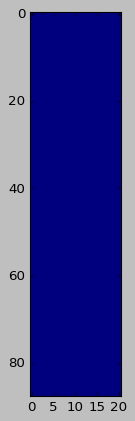

In [18]:
plt.imshow(UP_y_train[9999])

In [28]:
batch_size = 15
epochs = 300
n_examples = UP_X_train.shape[0]
n_batches = n_examples // batch_size

from tqdm import tnrange
for epoch in tnrange(epochs):
    for batch in tnrange(n_batches):
        UP_x_batch = UP_X_train[batch*batch_size: (batch+1) * batch_size]
        UP_y_batch = UP_y_train[batch*batch_size: (batch+1) * batch_size]
        UP_loss = UP_train_fun(UP_x_batch,UP_y_batch)
    print("UP", UP_loss)
#     for batch in tnrange(n_batches):
#         DOWN_x_batch = DOWN_X_train[batch*batch_size: (batch+1) * batch_size]
#         DOWN_y_batch = DOWN_y_train[batch*batch_size: (batch+1) * batch_size]
#         DOWN_loss = DOWN_train_fun(DOWN_x_batch,DOWN_y_batch)
#     print("DOWN", DOWN_loss)


2549/|/ 76%|| 2549/3333 [01:14<00:22, 34.18it/s]

KeyboardInterrupt: 

In [29]:
UP_test_fun(UP_X_test[:30], UP_y_test[:30])

array(0.0017383826272895995)

NameError: name 'y_tr' is not defined

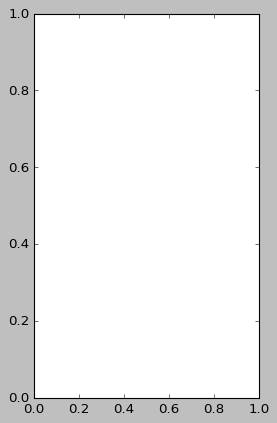

In [32]:
b = 23
plt.subplot(1, 2, 1)
plt.imshow(y[b])
plt.subplot(1, 2, 2)
plt.imshow(UP_predict_probas(UP_X_test[b:b+1])[0])

In [ ]:
1

In [23]:
import pickle
pickle.dump(lasagne.layers.get_all_param_values(up_nn), open('up_nn', 'wb'),protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
1